# Support Vector Machines <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

A Support Vector Machines (SVM) is a powerful model that can perform either linear or nonlinear classification, regression and outlier detection. SVMs are suited for classification of complex but small/medium sized datasets.

1. [Linear SVM Classification](#linear)
2. [Gradient Descent](#gradient)
    1. [Batch Gradient Descent](#bgd)
    2. [Stochastic Gradient Descent](#sgd)
    3. [Mini-batch Gradient Descent](#mbgd)
3. [Polynomial Regression](#polyreg)
4. [Learning Curves](#learn)
5. [Regularized Linear Models](#regular)
    1. [Ridge Regression](#ridge)
    2. [Lasso Regression](#lasso)
    3. [Elastic Net Regression](#elastic)
    4. [Early Stopping](#early)
6. [Logistic Regression](#logistic)
4. [Explore the data](#explore)
5. [Training and test sets](#traintest)
6. [Visualize the training data](#visualize)
7. [Feature engineering testing](#featureng)
8. [Data preperation](#preperation)
9. [Transformer pipelines](#pipelines)
10. [Select and Train a Model](#firstmodels)
11. [Model baselines](#baselines)
12. [Fine-tuning hyperparameters](#gridsearch)
13. [Analyzing the best estimators](#bestestimators)
14. [Evaluate system on test data](#evaluatetesth)
14. [Summary](#summary)

In [119]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-whitegrid')

## 1. Linear SVM Classification <a class="anchor" id="linear"></a>
[[back to top]](#top)

A linear SVM classifier, as its name implies, draws a linear decision boundary for classification. The SVM attempts to separate the classes and stay as far away from the closest training instances as possible. You can think of the classifier as fitting the widest possible street between the classes, this is known as *large margin classification*. The decision boundary is fully determined (**supported**) by the instances close to the boundary, or edge of the street. Adding instances "off the street" far from the boundary envelope will not affect the boundary. The instances located near the edge, are called **support vectors**.

> SVMs are sensitive to the feature scales, and feature scaling like `StandardScaler()` is recommended.

#### Example:
Let's first look at an example using the Iris dataset to separate Iris-Versicolor Iris-Setosa using pedal length and width.

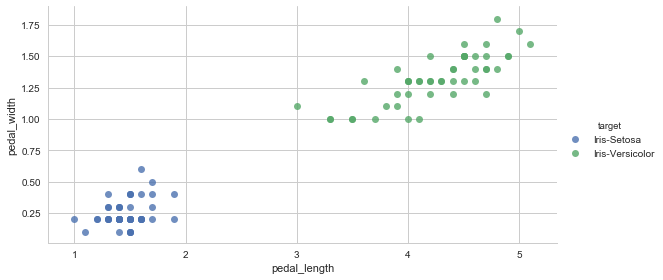

In [120]:
from sklearn.svm import SVC
from sklearn import datasets

# Load iris dataset
iris = datasets.load_iris()
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Only look at versicolor and setosa
inds = (y==0) | (y==1)
X = X[inds,:]
y = y[inds]

# Let's make a visualization looking at pedal width and class
data = pd.DataFrame(X,columns=['pedal_length','pedal_width'])
data['target'] = y
data.loc[data['target'] == 0, 'target'] = 'Iris-Setosa'
data.loc[data['target'] == 1, 'target'] = 'Iris-Versicolor'

sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)

In [126]:
def plot_decision_boundary(pipe,x0,ax=None,pltSVs=True):
    w  = pipe.named_steps['svm'].coef_[0]
    b  = pipe.named_steps['svm'].intercept_[0]
    scales = pipe.named_steps['scaler'].scale_
    means  = pipe.named_steps['scaler'].mean_

    # At the decision boundary: w0*x0+w1*x1 + b = 0, so can solve for x1
    # x1 = -(b+w0*x0)/w1
    x0_scaled = (x0-means[0])/scales[0]
    x1_scaled = -(b + w[0]*x0_scaled)/w[1]
    x1 = x1_scaled*scales[1] + means[1]
    
    # Get margin for decision boundary
    margin = 1/(w[1]) 
    gutter_up   =  (x1_scaled + margin)*scales[1] + means[1]
    gutter_down =  (x1_scaled - margin)*scales[1] + means[1]

    # Draw decision boundary
    if ax is None:
        plt.plot(x0,x1,'k',lw=2.0)
        plt.plot(x0,gutter_up,'k--',lw=1.0)
        plt.plot(x0,gutter_down,'k--',lw=1.0)
    else:
        ax.plot(x0,x1,'k',lw=2.0)
        ax.plot(x0,gutter_up,'k--',lw=1.0)
        ax.plot(x0,gutter_down,'k--',lw=1.0)
    
    if pltSVs:
        # Draw support vectors
        svecs = pipe.named_steps['svm'].support_vectors_
        svecs = svecs*scales[np.newaxis,:] + means[np.newaxis,:]
        if ax is None:
            plt.scatter(svecs[:,0],svecs[:,1],s=150,facecolor='None',edgecolor='r',lw=3.0)
        else:
            ax.scatter(svecs[:,0],svecs[:,1],s=150,facecolor='None',edgecolor='r',lw=3.0)
    
    

(0, 2.0)

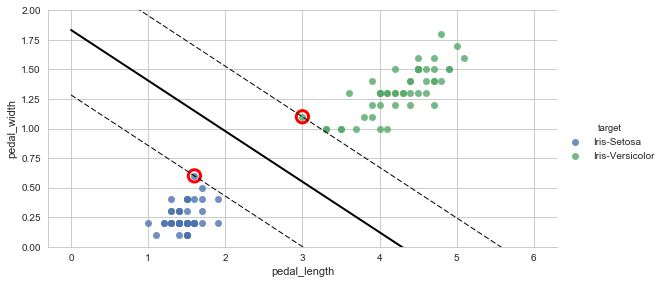

In [122]:
# Train SVC classifier
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='linear',C=float('inf')))]) # large C for hard margin classification
svc_pipe.fit(X,y)

### Draw boundary
x0 = np.linspace(0,6,100) #pedal lengths
sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)
plot_decision_boundary(svc_pipe,x0)
plt.ylim([0,2.0])

The solid black line above is the decision boundary from the Linear SVM classifier, the dashed black lines represent the *margin* or edges of the road. The red circled instances are the support vectors. The reason why the support vectors are on the edges of the road is because we fit the widest road possible.

### Soft Margin Classification:

If we have the constraint that all instances be 'off the street', this is called **hard margin classification**. It only works if the data is linearly separable, and it is quite sensitive to outliers. If the data is not linearly separable, then hard margin classification will fail. If an outlier is present, then the boundary may not generalize well.

An example is shown below where we add an Iris-Setosa instance close to Iris-Versicolor:

(0, 2.0)

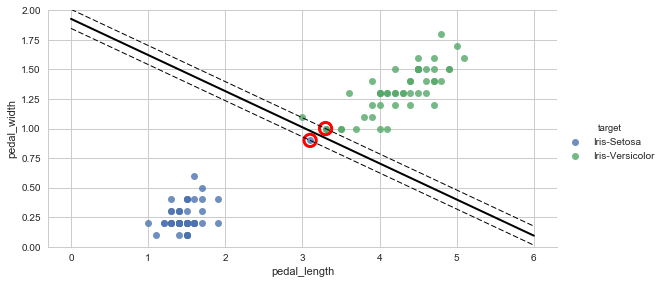

In [123]:
# Add an outlier training instance for setosa 
X_out = np.vstack([X, [3.1,0.90]])
y_out = np.append(y,0)
data.loc[len(data)] = [3.1,0.90,'Iris-Setosa']

# Train classifier
svc_pipe.fit(X_out,y_out)

# Draw decision boundary
sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)
plot_decision_boundary(svc_pipe,x0)
plt.ylim([0,2.0])


Above we can see the effect of an outlier for hard margin classification. It places the boundary too close to Iris-Versicolor.

To avoid issues with hard margin classification, it is preferable to have a more flexible model. The objective is to obtain a balance where the road can be as large as possible, and to limit the **margin violations** (instances that end up in the middle of the road). This is called **soft margin classification**, which can be used for datasets that are not entirely linearly separable. 

In `sklearn`, the balance can be controlled with the hyperparameter `C`. A small value of `C` leads to a wider street but more margin violations. A large value of `C`, like we had in the last example with `C=float('inf')` can lead to a narrow road with no margin violations. 

> Thus the `C` hyperparameter controls a SVM model's degree of regularization, if you find the model is overfitting the training data, you can decrease `C`.


#### Example:
Here we will try to classify Iris-Virginica versus Iris-Versicolor, which are not linearly separable in terms of pedal length and width.

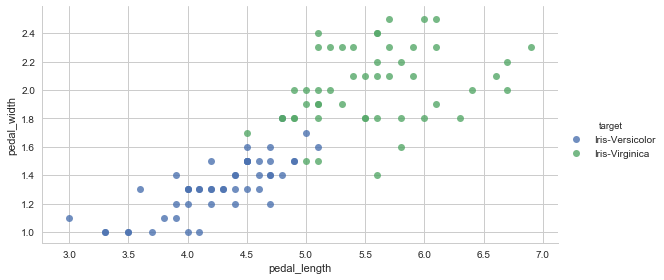

In [124]:
# Load iris dataset
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Only look at versicolor and virginica
inds = (y==1) | (y==2)
X = X[inds,:]
y = y[inds]

# Let's make a visualization looking at pedal width and class
data = pd.DataFrame(X,columns=['pedal_length','pedal_width'])
data['target'] = y
data.loc[data['target'] == 1, 'target'] = 'Iris-Versicolor'
data.loc[data['target'] == 2, 'target'] = 'Iris-Virginica'

sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)

Now let's evaluate different values for the hyperparameter `C`:

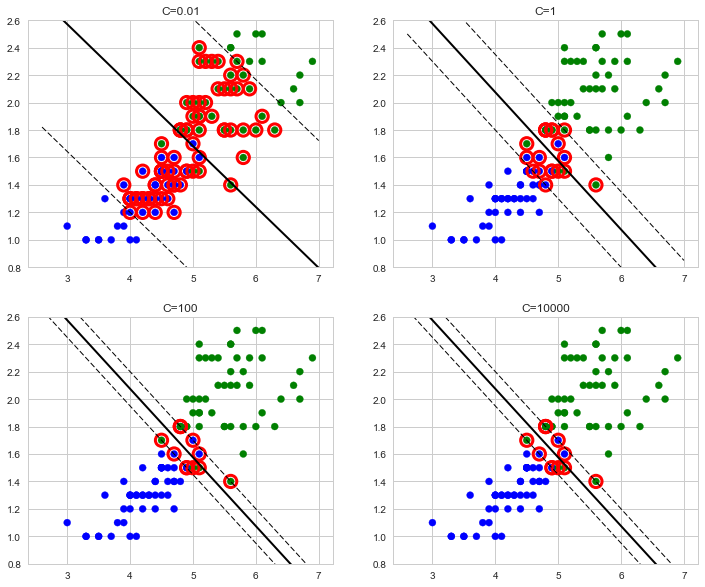

In [125]:
from matplotlib import colors as c

cmap= c.ListedColormap(['b','g'])

fig,(axes) = plt.subplots(2,2,figsize=[12,10])
x0=np.linspace(2.6,7,100)

# Loop through different values of C
for C,ax in zip([0.01,1,100,10000],axes.ravel()):
    # Train classifier
    svc_pipe.set_params(svm__C=C).fit(X, y)
    # Draw decision boundary
    ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
    plot_decision_boundary(svc_pipe,x0,ax=ax)
    ax.set_ylim([0.8,2.6])
    ax.set_title('C={}'.format(C))
    

We can see above that for very small values of `C`, almost all of the instances are support vectors, but for larger values the width of the road becomes smaller until it cannot become any narrower as the data is not completely linearly separable. 

Note we could have also used `sklearn`'s `LinearSVC` class, it is faster than using `SVC` with the linear kernel. The `LinearSVC` class regularizes the bias term, so the training data should be centered first by subtracting the mean. The hyparameter `loss` should be set to `'hinge'`, since it is not the default, and will explain this later. The downside is that `LinearSVC` does not output the support vectors if they are needed. And for even faster performance, the `dual` hyperparameter can be set to `False`, unless there are more features than training instances.

> Another option is to use `SGDClassifier` with `loss='hinge'` and `alpha=1/(m*C)`, it does not converge as quickly as `LinearSVC` but can handle even larger datasets that do not fit into the memory for out-of-core training.

## 2. Nonlinear SVM Classification <a class="anchor" id="nonlinear"></a>
[[back to top]](#top)

Many datasets are not linearly separable. One way to tackle this with a Linear SVM classifier is to add more features, like polynomial features which might make the dataset linearly separable. 

Let's look at a simple example first: 

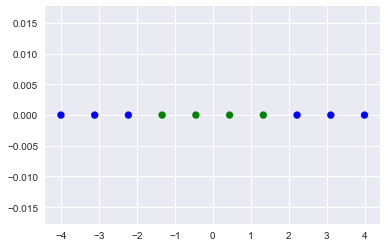

In [13]:
# 1-D example
x1 = np.linspace(-4,4,10)
y  = np.zeros(len(x1))
y[(x1<2) & (x1>-2)] = 1

# Plot example
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= c.ListedColormap(['b','g'])
ax.scatter(x1,np.zeros(len(x1)),c=y, cmap=cmap)

There is no way to separate the data above linearly, however if we introduce a higher order polynomial term, and solve like we did earlier with a linear SVM.

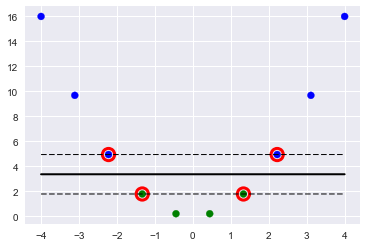

In [22]:
# Introduce a 2nd degree polynomial term
X = np.c_[x1,x1**2]
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= c.ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)

# Make pipeline
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='linear',C=100))])
svc_pipe.fit(X,y)
x0 = np.linspace(-4,4,50)
plot_decision_boundary(svc_pipe,x0,ax=ax)


We can see with the addition of a second feature the resulting dataset is perfectly linearly separable. 

Now let's look a bit harder example with the moons dataset:

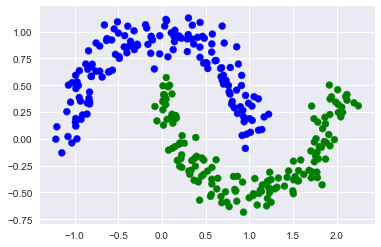

In [66]:
from sklearn.datasets import make_moons

# Load data
X,y = make_moons(300,noise=0.1)

# Plot data
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= c.ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)

Like in our first example, there is no way to separate the two classes by drawing a straight line above. We will add polynomial features and then use a Linear SVM to classify the data:

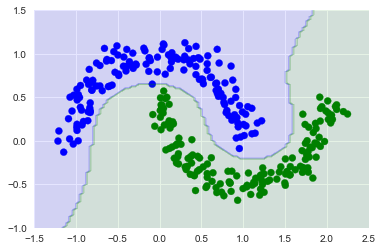

In [67]:
from sklearn.preprocessing import PolynomialFeatures

# Make pipeline
svc_pipe = Pipeline([("poly", PolynomialFeatures(degree=3)),
                     ("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='linear',C=10))])
svc_pipe.fit(X,y)
x0 = np.linspace(-1.5,2.5,50)
fig,ax = plt.subplots(1,figsize=[6,4])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
# Plot boundaries
x1,x2 = np.meshgrid(np.linspace(-1.5,2.5,100),np.linspace(-1,1.5,100))
Xnew = np.c_[x1.ravel(),x2.ravel()]
ypred = svc_pipe.predict(Xnew).reshape(x1.shape)
CS = ax.contourf(x1, x2, ypred,cmap=cmap,alpha=0.1)

### Polynomial Kernel

As we saw above, adding polynomial features simple to implement, but a too low degree polynomial cannot deal with very complex datasets, and a high degree creates a large number of features making the model slow.

Luckily, with SVMs a mathematical technique called a *kernel* can be used to get the same result as if many polynomial features were added, without actually having to add them. In the `SVC` class we can set `kernel='poly'` and `degree=10`. We can also tune a coefficient called `coef0` which specifies how much the model is influenced by high-degree polynomials versus low-degree polynomials.


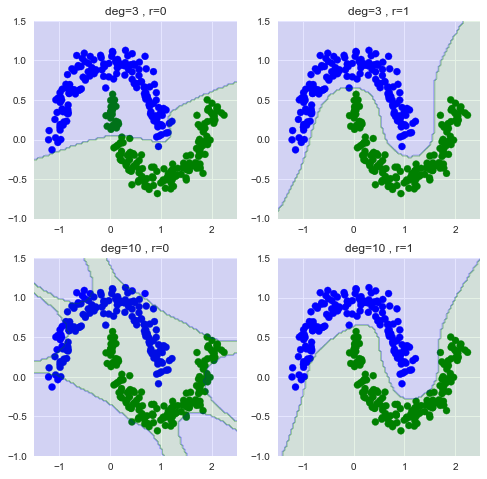

In [69]:
fig,(axes) = plt.subplots(2,2,figsize=[8,8])

svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='poly',C=10))])

# Loop through different values of poly degree and r(coef0)
axes=axes.ravel()
i=0
for deg in [3,10]:
    for r in [0,1]:
        # Train classifier
        svc_pipe.set_params(svm__coef0=r,svm__degree=deg).fit(X, y)
        # scatter and draw contours
        ax = axes[i]
        ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
        ypred = svc_pipe.predict(Xnew).reshape(x1.shape)
        CS = ax.contourf(x1, x2, ypred,cmap=cmap,alpha=0.1)
        i+=1
        ax.set_title('deg={} , r={}'.format(deg,r))    

We can see that in this case, the `r` hyperparameter makes a big difference for the polynomial kernel depending what value it is set to.

### Adding Similarity Features

In addition to adding polynomial features to tackle nonlinear problems, we can also add features computed using a *similarity function* that measure how much each instance resembles a particular *landmark*. 

As an example we can use the 1-D dataset we used earlier. We can put landmarks at $x_1=-2$ and $x_1=1$. The similarity function we can use is called the *Gaussian Radial Basis Function (RBF)*. 

A *radial basis function* depends only on the distance from the origin or landmark, so that $\phi(x,c) = \phi(||x-c||)$ where $x$ and $c$ are a point and the landmark. The Gaussian RBF is commonly used has the form of:

$ \phi(x,c) = e^{-\gamma||x-c||^2} $

where $\gamma$ controls the width of the Gaussian function, where the function varies from 0 far away from the landmark, and 1 at the landmark. The values of the function for all the instances becomes a new feature. 

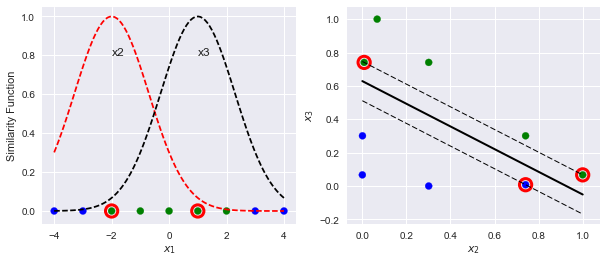

In [64]:
# 1-D example
x1 = np.linspace(-4,4,9)
y  = np.zeros(len(x1))
y[(x1<=2) & (x1>=-2)] = 1

landmarks=np.array([-2,1])
# Plot example
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[10,4])
cmap= c.ListedColormap(['b','g'])
ax1.scatter(x1,np.zeros(len(x1)),c=y, cmap=cmap)
ax1.set_xlabel(r'$x_1$');ax1.set_ylabel('Similarity Function')
ax1.scatter(landmarks,np.zeros(2),s=150,facecolor='None',edgecolor='r',lw=3.0)
#Gaussian RBF for the landmarks
gamma = 0.3
X     = np.c_[x1]
x0 = np.linspace(-4,4,100)
colors=['r','k']
for i,l in enumerate(landmarks):
    gaussrbf_x1  = np.exp(-gamma*(np.absolute(x1-l)**2))
    gaussrbf_plt = np.exp(-gamma*(np.absolute(x0-l)**2))
    ax1.plot(x0,gaussrbf_plt,'--',color=colors[i])
    ax1.text(l,0.8,r'x{}'.format(i+2),fontsize=12)
    X = np.c_[X,gaussrbf_x1] #add new features

# Plot second set of features x2 and x3
ax2.scatter(X[:,1],X[:,2],c=y, cmap=cmap)
ax2.set_xlabel(r'$x_{2}$');ax2.set_ylabel(r'$x_3$')

# SVM decision boundary using similarity features
# Make pipeline
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='linear',C=100))])
svc_pipe.fit(X[:,1:],y)
plot_decision_boundary(svc_pipe,np.linspace(0,1,100),ax=ax2)

The plot on the right shows the labels for the two new similarity features, $x_2$ and $x_3$ which were the Gaussian RBF at landmarks $x_1=-2$ and $x_1=1$. As shown above, the similarity features are linearly separable using Linear SVM classification.

The parameter $\gamma$, controls the width of the Gaussian RBF similarity function, the larger the value of $\gamma$ the narrower the Gaussian RBF is. By increasing $\gamma$/narrowing the Gaussian RBF each training instance's range of influence is smaller for the similarity function.

How are the landmarks chosen? A simple approach is to create a landmark at the location of every instance in the dataset. This creates more dimensions and increases the chance that the transformed data is linearly separable. The downside is that a training set with $m$ instances and $n$ features gets transformed into a training set with $m$ instances and $m$ features (assuming the original features are dropped). If the training dataset is very large, there will be an equally large number of features.

### Gaussian RBF Kernel
Similar to the polynomial features method, the similarity method is a useful technique to make a dataset linearly separable. However it can be computational expensive on large training sets. Though like the *kernel* trick for polynomial features, SVM with `kernel='rbf'` allows similar results as if many similarity features were added without having to add them.

Let's redo the moon example earlier but this time with similarity features through SVM:



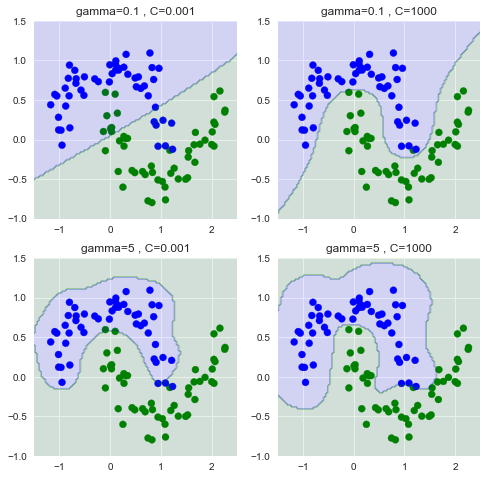

In [77]:
# Load data
X,y = make_moons(100,noise=0.15)

fig,(axes) = plt.subplots(2,2,figsize=[8,8])

# Classifier pipeline
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='rbf'))])

# Loop through different values of C and gamma
axes=axes.ravel()
i=0
for gamma in [0.1,5]:
    for C in [0.001,1000]:
        # Train classifier
        svc_pipe.set_params(svm__gamma=gamma,svm__C=C).fit(X, y)
        # scatter and draw contours
        ax = axes[i]
        ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
        ypred = svc_pipe.predict(Xnew).reshape(x1.shape)
        CS = ax.contourf(x1, x2, ypred,cmap=cmap,alpha=0.1)
        i+=1
        ax.set_title('gamma={} , C={}'.format(gamma,C))    

We can see the effects of changing the hyperparameters, `gamma` and `C` are above. Increasing `gamma` makes the Gaussian similarity function narrower so each instance's influence is smaller; and the decision boundary ends up being more irregular. A small `gamma` value has a wider bell shape curve and the instances have a larger range of influence, so the decision boundary ends up smoother. 

> Thus $\gamma$ or `gamma` acts as a regularization hyperparameter, if the model is overfitting you can reduce `gamma`, or if it is underfitting you can increase it.

#### What kernel should you use?
Since `LinearSVC` is much faster than `SVC(kernel='linear')`, especially if the training set is very large or has many features, you should always try the linear kernel first. If the training set is not too large, you should try the Gaussian RBF kernel, it works well in most cases. Then with extra-time can try other kernels using cross-validation and grid search, especially if one makes sense for training data structure. 



## 3. Computational Complexity <a class="anchor" id="computational"></a>
[[back to top]](#top)

The `LinearSVC` class is based on the *liblinear* library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick but scales almost linearly with the number of training instances and number of features. The algorithm takes longer if a high precision is required, controlled by the tolerance hyperparameter $\epsilon$ or `tol`. In most classification problems, the default tolerance is okay.

The `SVC` class uses the *libsvm* library, that supports the kernel trick. The training time complexity scales quadratically or higher with the training instances $m$. This means that it gets very slow when the number of instances are large (greater than 100,000). It is perfect for small to medium training set sizes. It scales well with the number of features, especially **sparse** features (like when one-hot encoding) where the algorithm scales roughly with the average number of nonzero features per instance.


| Class  | Time Complexity   | Out-of-core support   | Scaling?  | Kernel Trick  |
|---|---|---|---|---|
| `LinearSVC`  | $\mathcal{O}(mxn)$  |  No | Yes  | No  |
| `SGDClassifier`  | $\mathcal{O}(mxn)$  | Yes  | Yes  |No   |
| `SVC`  | $\mathcal{O}(m^2xn)$ to$\mathcal{O}(m^3xn)$  | No  | Yes  |  Yes |


## 4. SVM Regression <a class="anchor" id="svmregression"></a>
[[back to top]](#top)

Not only can SVM alogrithms support linear and nonlinear classification, but they can also support linear and nonlinear regression. The trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while balancing the margin violations, SVM regression tries to fit as many instances as possible on the road while limiting instances off of road.

The width of the road is controlled by the hyperparamer $\epsilon$. Opposite of classification, adding instances inside the margin does not affect the model's prediction.


In [1]:
from sklearn.svm import SVR

def plot_regression_fit(pipe,x0,X,y,ax=None):
    ypred = pipe.predict(x0)
    epsilon = pipe.named_steps['svm'].epsilon
    # Draw decision boundary
    if ax is None:
        plt.plot(x0,ypred,'k',lw=2.0)
        plt.plot(x0,ypred+epsilon,'k--',lw=1.0)
        plt.plot(x0,ypred-epsilon,'k--',lw=1.0)
    else:
        ax.plot(x0,ypred,'k',lw=2.0)
        ax.plot(x0,ypred+epsilon,'k--',lw=1.0)
        ax.plot(x0,ypred-epsilon,'k--',lw=1.0)
    
    # Draw support vectors
    svinds = pipe.named_steps['svm'].support_
    if ax is None:
        plt.scatter(X[svinds],y[svinds],s=150,facecolor='None',edgecolor='r',lw=3.0)
    else:
        ax.scatter(X[svinds],y[svinds],s=150,facecolor='None',edgecolor='r',lw=3.0)    

Let's generate some data for SVM regression:

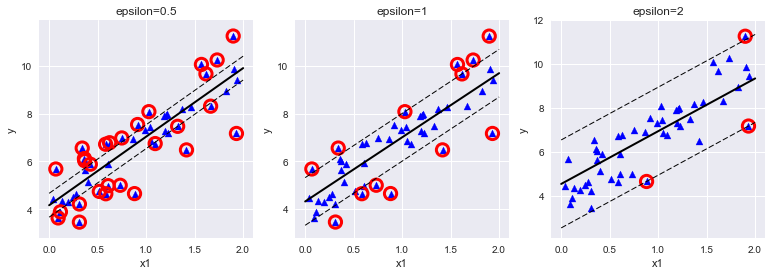

In [10]:
# Generate data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()
x0=np.linspace(0,2,100).reshape(-1,1)

#Train SVR model
svr_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVR(kernel='linear'))])

fig,axes = plt.subplots(1,3,figsize=[13,4])
# Loop through different values of epsilon
axes=axes.ravel()
for i,eps in enumerate([0.5,1,2]):
    # Train regressor
    svr_pipe.set_params(svm__epsilon=eps).fit(X, y)
    # scatter and draw contours
    ax = axes[i]
    ax.scatter(X[:,0],y,color='b',marker='^')
    plot_regression_fit(svr_pipe,x0,X,y,ax=ax)
    ax.set_title('epsilon={}'.format(eps))
    ax.set_xlabel('x1');ax.set_ylabel('y')

We can see that for larger values of `epsilon` there is a larger margin/road. The support vectors are the instances that then fall outside of the margin and affect the model's predictions.

We could have done the above with the class `LinearSVR` instead, but it does not retain the support vectors, but they are easy enough to calculate ourselves using `epsilon` and finding the instances that are out of the margin:

    off_margin = (np.abs(y-y_pred) >= svm_reg.epsilon)
    svinds     = np.argwhere(off_margin)

### Nonlinear SVM Regression

The same techniques in classification can be used to kernelize SVM models for regression. 

Let's look at an example with a quadratic training set:

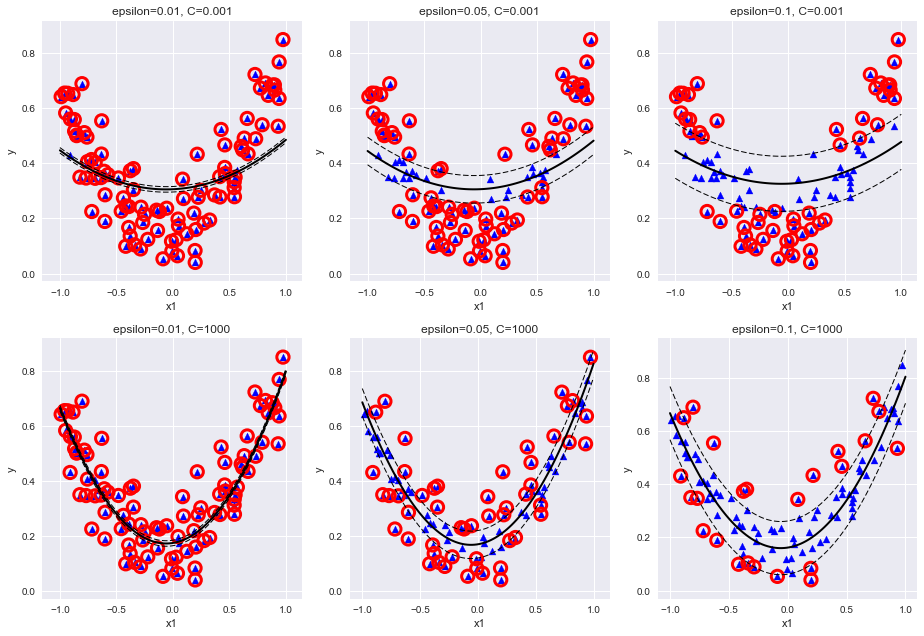

In [25]:
# Generate quadratic data
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

x0 = np.linspace(-1,1,100).reshape(-1,1)

# SVM Regression with poly kernel
svr_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVR(kernel='poly',degree=2))])

fig,axes = plt.subplots(2,3,figsize=[13,9])
# Loop through different values of epsilon and C
axes=axes.ravel()
i=0
for C in [0.001,1000]:
    for eps in[0.01,0.05,0.1]:
        # Train regressor
        svr_pipe.set_params(svm__epsilon=eps,svm__C=C).fit(X, y)
        # scatter and draw contours
        ax = axes[i]
        ax.scatter(X[:,0],y,color='b',marker='^')
        plot_regression_fit(svr_pipe,x0,X,y,ax=ax)
        ax.set_title('epsilon={}, C={}'.format(eps,C))
        ax.set_xlabel('x1');ax.set_ylabel('y')
        i+=1
fig.tight_layout()

We can see that for SVR regression, decreasing `C` increases the regularization of the model. We also see that increasing `epsilon` leads to a larger margin and fewer instances used as support vectors.

Just like classification `LinearSVR` scales with the number of instances, while `SVR` gets slow as the training set grows large.


## 5. SVM Thoery <a class="anchor" id="theory"></a>
[[back to top]](#top)

This section will touch on how SVMs algorithms work, beginning with linear SVM classifiers. For convection, unlike for Linear/Logistic Regression, where the bias weight term was $\theta_0$, and the bias term of 1's was added to the input vector, for SVMs it is more common to have the bias term called $b$ and the feature weights vector called $\textbf{w}$. No bias feature will be added to the input feature vectors.

### Decision Function and Predictions

The linear SVM classifier predicts the clas of a new instance $\textbf{x}$ by computing the decision function:

$\textbf{w}^T\cdot\textbf{x} + b = w_1 x_1 + \cdots + w_n x_n + b$,

if the result is positive the predicted class $\hat{y}$ is the positive class (1), or else it is the negative class (0). The line when the decision function is equal to 0 is the decision boundary we had earlier.

$ \hat{y} = \left\{
\begin{array}{l,c,l}
      0 & if& \textbf{w}^T\cdot\textbf{x} + b < 0 \\
      1  &if &\textbf{w}^T\cdot\textbf{x} + b \geq 0 \\
\end{array} 
\right.$

We can look visualizing the decision function for our first problem with pedal length and width for classification.

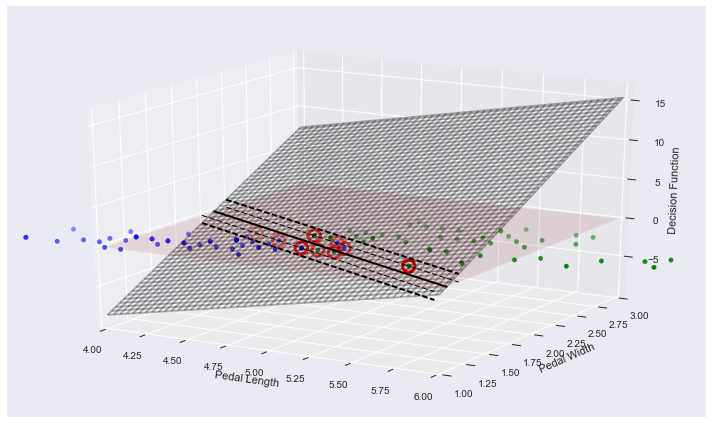

In [132]:
from sklearn import datasets
from matplotlib import colors as c
from mpl_toolkits.mplot3d import Axes3D

# Load iris dataset
iris =  datasets.load_iris()
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Only look at versicolor and virginica
inds = (y==1) | (y==2)
X = X[inds,:]
y = y[inds]

# Train SVC model
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
        ("svm", SVC(kernel='linear',C=100))]) 
svc_pipe.fit(X,y)

scales = svc_pipe.named_steps['scaler'].scale_
means  = svc_pipe.named_steps['scaler'].mean_


#Plot boundary
fig,ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection='3d'))
cmap= c.ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
ax.set_xlabel('Pedal Length');ax.set_ylabel('Pedal Width')
x1s= np.linspace(4,6,100);x2s=np.linspace(1,3,100)
x1,x2 = np.meshgrid(x1s,x2s)
plot_decision_boundary(svc_pipe,x1s,ax=ax)
ax.plot_surface(x1s,x2,0,color='r',alpha=0.1,cstride=100,rstride=100)

#Plot decision function 
Xs= np.c_[x1.ravel(),x2.ravel()]
Xsscaled = (Xs-means[np.newaxis,:])/scales[np.newaxis,:]
w = svc_pipe.named_steps['svm'].coef_[0]
b = svc_pipe.named_steps['svm'].intercept_[0]
DF = (Xsscaled.dot(w)+ b).reshape(x1.shape) #decision function

#Plot margins: w1*x1+w2*x2 + b = +/-1
margin_x2s1 = -(x1s-means[0])/scales[0]*[w[0]/w[1]]-(b-1)/w[1]
margin_x2s2 = -(x1s-means[0])/scales[0]*[w[0]]/w[1]-(b+1)/w[1]
ax.plot(x1s,margin_x2s1*scales[1]+means[1],1,'k--',lw=2.0)
ax.plot(x1s,margin_x2s2*scales[1]+means[1],-1,'k--',lw=2.0)

ax.plot_wireframe(x1, x2, DF, alpha=0.3, color="k")
ax.set_zlabel('Decision Function')
ax.set_xlim([4,6]);ax.set_ylim([1,3])
ax.view_init(20, 300)

fig.tight_layout()

The solid black line is the decision boundary we had earlier, and now we see that it is the line in the decision function plane where it equals 0. We see that the decision function is positive, the classification is for Iris-Versicolor, and when it is negative it classifies as Iris-Virginica. 

The dashed lines above indicate the margin, but they are also where the decision function is equal to $\pm 1$. Training a linear SVM classifier, we try to find the values of $\textbf{w}$ and $b$ that make the margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin). 

### Training Objective

The slope of the decision function is equal to the norm of the weight vector, $||\textbf{w}||$. If we divide the slope by 2, the points where the decision function is equal to $\pm 1$ will be twice as far away from the decision boundary. So dividing the slope by 2 will multiply the margin by 2. 

> The smaller the weight vector $\textbf{w}$, the larger the margin

Below is an example showing how changes in the weight vector values affect the margin:

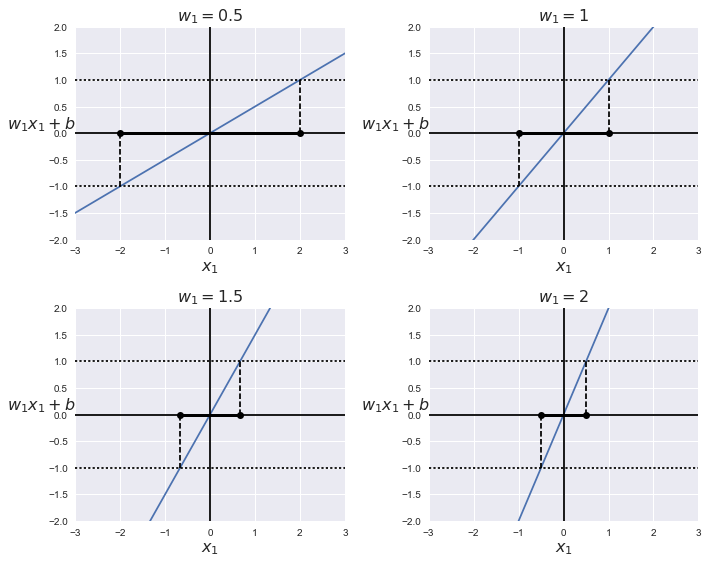

In [6]:
def plot_2D_decision_function(w, b, x1_lim=[-3, 3],ax=None):
    if ax is None: fig,ax = plt.subplots(1,figsize=[5,4])
    x1 = np.linspace(x1_lim[0], x1_lim[1], 100)
    df = w * x1 + b #decision function = w1*x1 + b 
    margin = 1 / w

    ax.plot(x1, df)
    ax.plot(x1_lim, [1, 1], "k:")
    ax.plot(x1_lim, [-1, -1], "k:")
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.plot([margin, margin], [0, 1], "k--")
    ax.plot([-margin, -margin], [0, -1], "k--")
    ax.plot([-margin, margin], [0, 0], "k-o", linewidth=3)
    ax.set_xlim(x1_lim);ax.set_ylim( [-2, 2])
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$w_1 x_1+b$  ", rotation=0, fontsize=16)
    ax.set_title(r"$w_1 = {}$".format(w), fontsize=16)

fig,(axes) = plt.subplots(2,2,figsize=[10,8])
for w,ax in zip([0.5,1,1.5,2], axes.ravel()):
    plot_2D_decision_function(w, 0,ax=ax)
fig.tight_layout()

In classification, we want to minimize $||\textbf{w}||$ to get a large margin, but we also want to avoid margin violations (hard margin) or limit the number of violations (soft margin). 

For the **hard margin**, we need the decision function to be greater than 1 for all positive instances, and less than -1 for negative instances. Let's define $t^{(i)}=-1$ for negative instances (if $y^{(i)}=0$) and $t^{(i)}=1$ for positive instances (if $y^{(i)}=1$), then we can express this constraint as:

$t^{(i)}(\textbf{w}^T\cdot \textbf{x}^{(i)}+b) \geq 1$ for all instances. So we can express the hard margin linear SVM classifier objective as the *constrained optimization* problem of:

minimize$\underset{\textbf{w},b}{}  \frac{1}{2}\textbf{w}^T\cdot \textbf{w}$

subject to: $t^{(i)}(\textbf{w}^T\cdot \textbf{x}^{(i)}+b) \geq 1$ for $i=1,2,\cdots, m$

> We are minimizing $\frac{1}{2}\textbf{w}^T\cdot \textbf{w}$ which is equal to $\frac{1}{2}||\textbf{w}||^2$, rather than minimizing $||\textbf{w}||$ since it gives the same values of $\textbf{w}$ and $b$ that minimize the half of its square. Optimization algorithms work better on differentiable functions, and $\frac{1}{2}\textbf{w}^T\cdot \textbf{w}$ derivative is simply $\textbf{w}$.

For the **soft margin** objective, we need to introduce a *slack* term, $\zeta^{(i)}\geq 0$ for each instance. $\zeta^{(i)}$ measures how much the i<sup>th</sup> instance is allowed to violate the margin. Thus there are 2 conflicting objectives:

1. Making the slack variable as small as possible to reduce the margin violations
2. Making $\frac{1}{2}\textbf{w}^T\cdot \textbf{w}$ as small as possible to increase the margin. 

The tradeoff is where the hyperparameter `C` comes in:

minimize $\underset{\textbf{w},b,\zeta}{}  \frac{1}{2} \textbf{w}^T\cdot \textbf{w} + C\sum\limits_{i=1}^{m}\zeta^{(i)} $

subject to: $t^{(i)}(\textbf{w}^T\cdot \textbf{x}^{(i)}+b) \geq 1-\zeta^{(i)}$ and $\zeta^{(i)}\geq 0$ for $i=1,2,\cdots, m$

### Quadratic Programming

The hard and soft margin problems are both convex quadratic optimization problems with linear constraints. These problems are known as *Quadratic Programming* (QP) problems. The general formulation is given by:

minimize $ \frac{1}{2} \textbf{p}^T\cdot \textbf{H}\cdot\textbf{p} + \textbf{f}^T\cdot\textbf{p}$

subject to: $\textbf{A}\cdot\textbf{p} \leq \textbf{b}$, where

* $\textbf{p}$ is a $n_p$-dimensional vector (number of parameters)
* $\textbf{H}$ is  a $n_p\times n_p$ matrix
* $\textbf{f}$ is a $n_p$-dimensional vector
* $\textbf{A}$ is a $n_c\times n_p$ matrix,$n_c$ is number of constraints
* $\textbf{b}$ is a $n_c$-dimensional vector

The constraint can be written as:

$\textbf{p}^T\cdot\textbf{a}^{(i)} \leq b^{(i)}$ for $i=1,2,\cdots,n_c$ where $\textbf{a}^{(i)}$ is the vector containing the elements of the i<sup>th</sup> row of $\textbf{A}$ and $b^{(i)}$ is the i<sup>th</sup> element of $\textbf{b}$.

If you set the QP parameters in the following way, you retrieve the hard margin linear SVM classifier objective:

* $n_p=n+1$ where $n$ is the number of features (+1 for the bias term)
* $n_c=m$, where $m$ is the number of instances
* $\textbf{H}$ is the $n_p\times n_p$ identity matrix, except with zero in the top-left (ignore the bias)
* $\textbf{f}=0$, an $n_p$ dimensional vector full of zeros
* $\textbf{b}=1$, an $n_c$ dimensional vector full of ones
* $\textbf{a}^{(i)}=-t^{(i)}\Omega^{(i)}$ where $\Omega^{(i)}$ is equal to $x^{(i)}$ with an extra bias feature $\Omega_0=1$.

The method to train a hard margin linear SVM classifier is to use a QP solver by passing the above arguments. The resulting $\textbf{p}$ vector will contain the bias term $b=p_0$ and the feature weights: $w_i=p_i$ for $i=1,2,\cdots,n$. The QP solver can solve the soft margin problem. Though to use the kernel trick we need to examine a different constrained optimization problem.

### The Dual Problem

With a constrained optimization problem, known as a **primal problem**, it is possible to express a different but related problem, known as its **dual problem**.

The solution to the dual problem usually gives a lower bound to the solution of the primal problem, but under certain conditions it can even have the same solution as the primal problem. Fortunately, the SVM problem meets the criteria so that solutions to the primal or dual problem are the same: the objective function is convex and the inequality constraints are differentiable and convex functions. The dual problem is derived from the primal problem by moving the constraints into the objective function via Lagrange multipliers. The Dual form of a linear SVM is:

minimize$_{\alpha} \frac{1}{2}\sum\limits_{i=1}^{m} \sum\limits_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)}t^{(j)}\textbf{x}^{(i)^T}\cdot \textbf{x}^{(j)} -\sum\limits_{i=1}^m \alpha^{(i)} $

subject to: $\alpha^{(i)} \geq 0$ for $i=1,2,\cdots,m$

Once the vector $\hat{\alpha}$ is found that minimizes this equation (using a QP solver), the weights $\textbf{w}$ and $\hat{b}$ can be found via:


$\textbf{w} = \sum\limits_{i=1}^{m} \hat{\alpha}^{(i)}t^{(i)}\textbf{x}^{(i)}$

$\hat{b} = \frac{1}{n_s} \sum\limits_{i=1,\hat{\alpha}^{(i)}>0 }^{m} (1-t^{(i)} (\textbf{w}^T\cdot\textbf{x}^{(i)}))$


> The Dual Problem is faster to solve than the primal when the number of training instances is smaller than the number of features. It allows to use the kernel trick as well

### Kernelized SVM

In the previous half moon example, we saw that a polynomial transformation to the 2-D dataset, allowed for classification. The 2nd degree polynomial transformation is:

$\phi(\textbf{x}) = \phi \begin{pmatrix}
           x_{1} \\
           x_{2} \\
         \end{pmatrix} = \begin{pmatrix}
                             x_{1}^2 \\                                                     \sqrt{2}x_{1}x_{2} \\
                               x_{2}^2 \\
                             \end{pmatrix}$
         

The transformed vector is 3-dimensional instead of 2-dimensional. Let's consider what happens for two 2-dimensional vectors, $\textbf{a}$ and $\textbf{b}$ for 2nd degree polynomial mapping and their dot product. 

$\begin{align}
\phi(\textbf{a})^T \phi(\textbf{b}) & 
                = \begin{pmatrix}
                           a_1^2 \\                                                      \sqrt{2}a_1 a_2 \\
                           a_2^2 \\
                   \end{pmatrix}^T
                   \begin{pmatrix}
                           b_1^2 \\                                                      \sqrt{2}b_1 b_2 \\
                           b_2^2 \\
                   \end{pmatrix} \\
               &= a_1^2b_1^2 + 2a_1b_1a_2b_2 + a_2^2b_2^2 \\
               &= (a_1b_1 + a_2b_2)^2 \\
               &=\left(  \begin{pmatrix}
                               a_{1} \\
                               a_{2} \\
                         \end{pmatrix}^T                     
                          \begin{pmatrix}
                               b_{1} \\
                               b_{2} \\
                         \end{pmatrix}
                \right)^2\\
               &= (\textbf{a}^T\textbf{b})^2
\end{align}$

The dot product of the transformed vectors is equal to the square of the dot product of the orginal vectors: $\varphi(\textbf{a})^T\varphi(\textbf{b}) = (\textbf{a}^T\textbf{b})^2$.

Now if the transformation, $\varphi$, is applied to all training instances, then the Dual Problem above, with the term: $\textbf{x}^{(i)^T} \textbf{x}^{(j)}$
, becomes $\varphi( \textbf{x}^{(i)})^T \varphi( \textbf{x}^{(j)})$.

If $\phi$ is the 2nd degree polynomial transformation, the term simply becomes $\left( \textbf{x}^{(i)^T} \textbf{x}^{(j)}\right)^2$. This is the trick! Don't need to transform the training instances at all, just replace the dot product by its square. This trick makes the computational process for a linear SVM much more efficient.

The kernel function, $K(\textbf{a},\textbf{b}) =  \left( \textbf{a}^{T} \textbf{b}\right)^2$ is the 2nd degree polynomial kernel. In machine learning, the kernel is a functiont that can compute the dot product   $\varphi( \textbf{a}^T \cdot \varphi( \textbf{b})$ based only on the orginal vectors $\textbf{a}$ and $\textbf{b}$ without having to compute the transformation $\phi$. 

#### Common Kenels:

 Kernel                  |   Transformation Trick for  $K(\textbf{a},\textbf{b}) $
------------------------- |--------------------------------------------------------
 Linear                  |$\textbf{a}^{T}\cdot \textbf{b}$             
 Polynomial              |$ (\gamma\textbf{a}^{T}\cdot\textbf{b} + r)^d$ 
 Gaussian RBF            |$exp(-\gamma||\textbf{a}-\textbf{b}||^2)$     
 Sigmoid                 |$tanh(\gamma\textbf{a}^{T}\cdot\textbf{b}+ r)$ 
       
> Mercer's Theorem: If a function $K(\textbf{a},\textbf{b}) $ respects mathematical conditions called *Mercer's conditions* ($K$ must be continuous, symmetric in its arguments) then there exists a function $\varphi$ that maps $\textbf{a}$ and $\textbf{b}$ into another space (with maybe higher dimensionality) such that $K(\textbf{a},\textbf{b})= \varphi( \textbf{a}^T \cdot \varphi( \textbf{b})$.

Previously we showed how to solve for $\textbf{w}$ and $b$ for the Primal solution from the Dual solution. But if we apply the kernel trick, we end up with equations that include the transformed $\varphi(\textbf{x}^{(i)})$, which might have many more dimensions than the original instances. 

We can use te formula for $\textbf{w}$ derived, into the decision function for a new instance $\textbf{x}^{(n)}$, and we retrieve an equation with only dot products between input vectors, so can use the kernel trick:

Decision Function:

$\begin{align}
h_{\textbf{w},\hat{b}}(\phi(\textbf{x}^{(n)}) )= & 
                = \textbf{w}^T\cdot\phi(\textbf{x}^{(n)}) + \hat{b}  \\ 
               &=\left( \sum\limits_{i=1}^{m} \hat{\alpha}^{(i)}t^{(i)}\phi(\textbf{x}^{(i)})\right)^T  \cdot\phi(\textbf{x}^{(n)}) + \hat{b} \\
               &=   \sum\limits_{i=1}^{m} \hat{\alpha}^{(i)}t^{(i)}\left( \phi(\textbf{x}^{(i)})\cdot \phi(\textbf{x}^{(n)})\right)  +   \hat{b} \\
               &= \sum\limits_{i=1,\hat{\alpha}^{(i)}>0}^{m}(1-t^{(i)} \hat{\alpha}^{(i)}t^{(i)}  K(\textbf{x}^{(i)},\textbf{x}^{(i)}) + \hat{b}  
\end{align}$

Because $\hat{\alpha}^{(i)}\neq 0$ only for support vectors, making predictions involves computing the dot product of the new input vector $\textbf{x}^{(n)}$ with only the support vectors, not all of the training instances. We can also compute the bias term $\hat{b}$ using the same trick:

$\begin{align}
\hat{b} &= \frac{1}{n_s} \sum\limits_{i=1,\hat{\alpha}^{(i)}>0}^{m}(1-t^{(i)}\textbf{w}^T\cdot \phi(\textbf{x}^{(i)}))\\
&=  \frac{1}{n_s} \sum\limits_{i=1,\hat{\alpha}^{(i)}>0}^{m}\left( 1-t^{(i)} \sum\limits_{j=1}^{m} \hat{\alpha}^{(j)}t^{(j)}\left( \phi(\textbf{x}^{(j)})\cdot \phi(\textbf{x}^{(i)})\right) \right)\\
&= \frac{1}{n_s}\sum\limits_{i=1,\hat{\alpha}^{(i)}>0}^{m}( 1-t^{(i)} \sum\limits_{j=1}^{m} \hat{\alpha}^{(j)}t^{(j)}K(\textbf{x}^{(i)}\textbf{x}^{(j)}) ) 
\end{align}$

## 6. Online SVMs <a class="anchor" id="online"></a>
[[back to top]](#top)

If we wanted to train a linear SVM compatible with online learning (incrementally updating the model as new instances arrive), one method is to use Gradient Descent. Using the `SGDClassifier` to minimize the following cost function, which is derived from the primal problem:

$J(\textbf{w},b) = \frac{1}{2}\textbf{w}^T\cdot\textbf{w} + C\sum\limits_{i=1}^m max(0,1-t^{(i)}(\textbf{w}^T \cdot\textbf{x}^{(i)}+b))   $

The first term in the cost function will push the model to have a small weight vector, $\textbf{w}$, leading to a larger margin. The second sum computes the total of all margin violations. For classification the margin violation is zero if the instance is off the road and on the correct side, else it is proportional to the distance to the correct side of the street. Minimizing the second term ensures that the model makes the margin violations as small and few as possible. Tuning the parameter `C` such as making it small, leads to more margin violations and more regularized model. Increasing `C` promotes fewer margin violations and is less regularized model. 

The function $ max(0,1-t)$ is called the **Hinge Loss Function** which finds the support vectors. It is equal to 0 when $t\geq 1$. The derivative of the function is equal to -1 if $t<1$, and 0 when $t>1$. It is not differentiable at $t=1$, but like Lasso Regresion, you can still use Gradient Descent using any subderivative at t=0 (any value between -1 and 0).


Below is a plot of Hinge Loss and it's derivative:

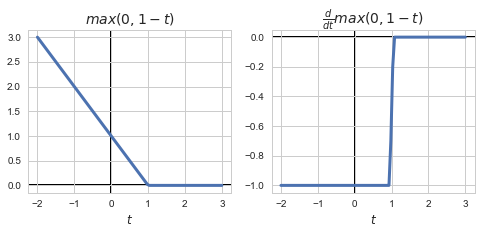

In [30]:
# Hinge Loss Function
t  = np.linspace(-2,3,100)
HL = np.where(1 - t < 0, 0, 1 - t)# max(0,1-t)

# Derivative 
grad = np.gradient(HL)/np.diff(t)[0]

# Plotting
fig,(ax1,ax2)= plt.subplots(1,2,figsize=[8,3])
ax1.plot(t,HL,lw=3.0)
ax1.set_title(r'$max(0,1-t)$',fontsize=14);ax1.set_xlabel(r'$t$',fontsize=12)
ax1.axhline(y=0, c='k',zorder=0,lw=2);ax1.axvline(x=0, c='k',zorder=0,lw=2)
ax2.plot(t,grad,lw=3.0)
ax2.set_title(r'$\frac{d}{dt}max(0,1-t)$',fontsize=14);ax2.set_xlabel(r'$t$',fontsize=12)
ax2.axhline(y=0, c='k',zorder=0,lw=2);ax2.axvline(x=0, c='k',zorder=0,lw=2)

### Example: Linear SVM with Batch Gradient Descent

We will use the cost function defined above to implement our own estimator with Batch Gradient Descent and also compare it to using the online `SGDClassifier` with `loss='hinge'`, as well as with `LinearSVC`.  The dataset we'll use is the Iris-Virginica vs Iris-Versicolor pedal length and width.

In [128]:
# Load iris dataset
iris =  datasets.load_iris()
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Only look at versicolor and virginica
inds = (y==1) | (y==2)
X = X[inds,:]
y = y[inds]
y = (y==2).astype(int).reshape(-1,1)


In [108]:
# Linear SVM with Gradient Descent 
from sklearn.base import TransformerMixin,BaseEstimator

class LinearSVM_GD(BaseEstimator):

    def learning_schedule(self,nepoch):
        return self.eta0/(nepoch+self.eta1)
    
    def __init__(self,n_epochs=5000,eta0=1,eta1=10000,C=1,random_state=23): #
        self.n_epochs=n_epochs
        self.eta0 = eta0
        self.eta1 = eta1
        self.C    = C
        self.Js = []
        self.random_state= random_state

    def fit(self,X,y):
        # Batch GD
        m = len(X) # no of instances
        n = X.shape[-1] # no of features
        
        # Intialize w and b
        np.random.seed(self.random_state)
        w = np.random.randn(n,1)
        b = 0 
        
        # Set up t^(i) function which is -1 for y==0 and 1 for y==1
        t  = 2*y-1
        Js = []
        for epoch in range(self.n_epochs):
            #First calculate decision function and get the support 
            # vectors (i.e. where DF < 1)
            support_vectors_idx = ((t*X).dot(w) + t*b < 1).ravel() # change from (m,1) to (m)
            X_sv = X[support_vectors_idx,:]
            t_sv = t[support_vectors_idx]
            
            #Calculate the objective function two terms
            J1 = 0.5*w.T.dot(w)[0][0] #weight minimization
            HL = 1-t_sv*(X_sv.dot(w) + b) #hinge loss function for  support vectors
            J2 = self.C*np.sum(HL)
            J  = J1 + J2
            self.Js.append(J)
            
            # Gradients of cost function with respect to w and b
            # Recall for the HL the derivative of (1-t(w^T Xsv)) =  -tXsv
            w_grad = w - self.C*np.sum( t_sv*X_sv,axis=0).reshape(-1,1)
            b_grad =  -self.C*np.sum(t_sv) # d/db(- C*np.sum( 1-t(wTXsv + b)))
            
            # Update w and b 
            w = w - self.learning_schedule(epoch)*w_grad
            b = b - self.learning_schedule(epoch)*b_grad
        
        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        #Final support vectors
        support_vectors_idx = ((t*X).dot(w) + t*b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        
    def decision_function(self,X):
        return X.dot(self.coef_[0] + self.intercept_[0])
    
    def predict(self,X):
        return(self.decision_function(X) >=0).astype(np.float65)
    

Let's test out our Batch Gradient Descent Linear SVM:

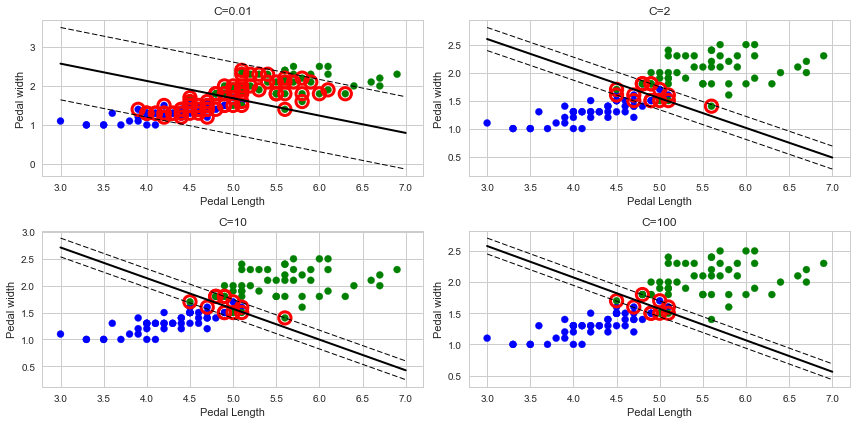

In [115]:
from matplotlib import colors as c

# Setup our classifier
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", LinearSVM_GD(n_epochs =60000,eta0=10,eta1=1000,
                                          C=2, random_state=2))])

#Plot for different values of C
cmap= c.ListedColormap(['b','g'])
fig,axes =plt.subplots(2,2,figsize=[12,8])
for C,ax in zip([0.01,2,10,100],axes.ravel()):
    svc_pipe.set_params(svm__C =C).fit(X, y)
    ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
    plot_decision_boundary(svc_pipe,np.linspace(3,7,100),ax=ax)
    ax.set_xlabel('Pedal Length');ax.set_ylabel('Pedal width')
    ax.set_title('C={}'.format(C))
fig.tight_layout()

Let's repeat the above for a couple of `C` values using `SGDClassifier`, though now recall that `alpha=1/(m*C)`:

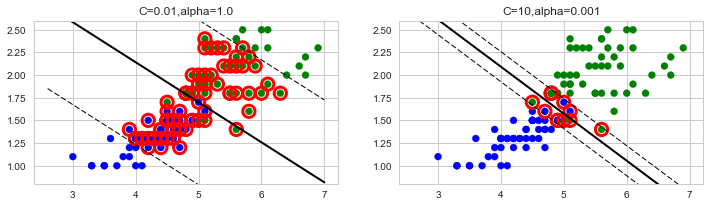

In [139]:
from sklearn.linear_model import SGDClassifier
sgd_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SGDClassifier(loss='hinge',n_iter=100,random_state=42))   ])

fig,(axes) = plt.subplots(1,2,figsize=[12,3])

# Loop through different values of C
m = len(X)
t = 2*y-1 #-1 if y=0 and 1 if y=1

for C,ax in zip([0.01,10],axes.ravel()):
    ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
    # Need alpha and not C
    alpha = 1/(m*C)
    # Train classifier
    sgd_pipe.set_params(svm__alpha=alpha).fit(X, y.ravel())
    # Get support vectors from SGD, get weights first
    sgdclf = sgd_pipe.named_steps['svm']
    thetas = np.r_[sgdclf.intercept_[0],sgdclf.coef_[0]]
    # Need to scale
    Xscale = sgd_pipe.named_steps['scaler'].transform(X)
    X_b = np.c_[np.ones(m),Xscale] #add bias term
    support_vectors_idx = ((t*X_b).dot(thetas) < 1).ravel()
    SVs = X[support_vectors_idx]
    ax.scatter(SVs[:,0],SVs[:,1],s=150,facecolor='None',edgecolor='r',lw=3.0)
    plot_decision_boundary(sgd_pipe,x0,ax=ax,pltSVs=False)
    ax.set_ylim([0.8,2.6])
    ax.set_title('C={},alpha={}'.format(C,alpha))

## 7.  Exercises <a class="anchor" id="exercises"></a>
[[back to top]](#top)

> **1.**  What is the fundamental idea behind Support Vector Machines?

The main idea is to fit the widest road possible between two classes while minimizing margin violations (or for regression trying to fit the widest road with as few instances outside of the road). The objective for classification is to have the largest margin between the decision boundary and the training instances. Another key idea is that kernels can be used on non linearly separable data for classification, and is computationally efficient since it does not have to compute the transformation on the instances (e.g. a $n$ degree polynomial). 

> **2.** What is a support vector?

Instances that fall just on or inside the road (margin) for the model. The decision boundary is entirely determined by the support vectors and not instances outside of the margin. The instances off the road could be removed and it would not change the decision boundary. Computing the weight vector and thus the predictions from the weight vector only requires the support vectors, not the whole training set.

> **3.** Why is it important to scale the inputs using SVMs?

The width of the road in the feature-space will be greatly affected if the features have differing scales, and will be biased to the feature with the largest scale, and neglect small features.

> **4.** Can an SVM output a confidence score associated with a classification?What about a probability?

An SVM can output the distance between an instance and the decision boundary, which can be taken as the confidence score, but there is no probability. There is a way to get probabilities though for SVM using `sklearn` using the hyperparameter: `probability=True` which will use a Logistic Regression on the SVM's scores, so you can access the `predict_proba()` and `predict_log_proba()` methods.


> **5.** Should the primal or dual form of the SVM problem be used to train a model on a training set with millions of instances and hundreds of features?

The Dual form is faster to solve than the primal when the number of training instances is smaller than the number of features. So for the question above, if speed is priority then the primal form would be faster. But the dual form allows the kernel trick to be applied so the extra computational time might be worth it.

> **6.** Suppose you trained an SVM classifier with an RBF kernel, and it seems to underfit the training set: should you increase or decrease the $\gamma$ (`gamma`) parameter? What about `C`?

Gamma ($\gamma$) acts as a regularization hyperparameter, if the model is overfitting you can reduce gamma, or if it is underfitting you can increase $\gamma$. This is because increasing $\gamma$ makes the Gaussian similarity function narrower so each instance's influence is smaller; and the decision boundary ends up being more irregular. A small $\gamma$ value has a wider bell shape curve and the instances have a larger range of influence, so the decision boundary ends up smoother. `C` is also regularization parameter that controls the margin violations, increasing `C` acts to constrain the number of violations so that the road is smaller and the SVM is less likely to underfit, compared to decreasing `C` which may be necessary to regularize or prevent overfitting. 

> **7.** How should you set the QP parameters ($\textbf{H}, \textbf{f}, \textbf{A},$ and $\textbf{b}$), to solve the soft margin linear SVM classifier using an off-the-shelf QP solver?

In the hard margin problem, the number of of parameters, $n_p = n+1$, and the number of constraints is equal to $n_c=m$. For the soft margin problem, $n_p = n+m+1$ and $n_c= 2m$, so:

* $\textbf{H}$ is equal to a  $n+1+m\times n+1+m$  identity matrix along $n_p$, with zero in the top-left (ignore the bias) and $m$ columns on the right and $m$ rows on the bottom with 0's.
* $\textbf{f}$  an $n+m+1$ dimensional vector full of zeros for $n_p$ and $m$ elements equal to the hyperparameter `C`.
* $\textbf{b}$ is a $2m$ dimensional vector full of ones for $m$ elements and full of zeros for another $m$ elements.
* $\textbf{A}$ is a  $2m×n+m+1$ matrix of the constraints, with an extra $m\times m$ identity matrix appended to the right, and negative identity matrix just below it.

> **8.** Train a `LinearSVC` on a linearly separable dataset, then train an `SVC` and `SGDClassifier` on the same dataset to see if they can get the same model:

We will use one of the first datasets in this notebook, the Iris-Setosa vs. Iris-Versicolor:

In [148]:
from sklearn.svm import LinearSVC

# Load iris dataset
iris = datasets.load_iris()
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Only look at versicolor and setosa
inds = (y==0) | (y==1)
X = X[inds,:]
y = y[inds]

# LinearSVC
lsvc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", LinearSVC(loss='hinge'))])
# SVC
svc_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SVC(kernel='linear',C=np.float('inf') ))])
# SGD 
sgd_pipe = Pipeline([("scaler",StandardScaler() ), 
                     ("svm", SGDClassifier(loss='hinge',n_iter=10000,random_state=42,
                                alpha=0.00001,learning_rate='constant',
                                eta0=0.001))])

# Train classifiers
lsvc_pipe.fit(X,y)
w_lsvc = lsvc_pipe.named_steps['svm'].coef_[0]
b_lsvc = lsvc_pipe.named_steps['svm'].intercept_[0]
print('LinearSVC params: w={}, b={}'.format(w_lsvc,b_lsvc))

svc_pipe.fit(X,y)
w_svc = svc_pipe.named_steps['svm'].coef_[0]
b_svc = svc_pipe.named_steps['svm'].intercept_[0]
print('SVC params: w={}, b={}'.format(w_svc,b_svc))

sgd_pipe.fit(X,y)
w_sgd = sgd_pipe.named_steps['svm'].coef_[0]
b_sgd = sgd_pipe.named_steps['svm'].intercept_[0]
print('SGD params: w={}, b={}'.format(w_sgd,b_sgd))

LinearSVC params: w=[ 1.06123931  1.00026895], b=0.29581737908937844
SVC params: w=[ 1.1223101   1.02531081], b=0.3193357719449197
SGD params: w=[ 1.11304482  1.03662407], b=0.3140000000000002


Can see above that all of the weight vector coefficients and bias term are close to eachother for the linearly separable dataset. 

> **9.** Train a SVM for classification on the MNIST dataset. Since SVM classifiers are binary, you should use the one-versus-all to classify the 10 digits. Since the dataset is so large, it is wise to tune the hyperparameters on a small set to speed up the process.

First thing to do is to load the dataset like in the previous chapter:

In [149]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist["data"]
y = mnist["target"]
print(X.shape,y.shape)

(70000, 784) (70000,)


### Train/test splitting:

The MNIST dataset is already split into a training set with the first 60,000 images and a test set with the last 10,000 images. We'll also shuffle the training set since it is ordered by digits 0-9.

In [160]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

# We'll also take a subset of training and testing for quick computing, they are already shuffled
subset=0.15
Nsubs = int( subset*len(y_train) )
X_train_sub = X_train[:Nsubs]; y_train_sub=y_train[:Nsubs]

Let's quickly train a Linear SVM and see how it does:

In [161]:
from sklearn.metrics import accuracy_score

svc_pipe = Pipeline([ ('scale', StandardScaler() ),
                       ('svm',  LinearSVC() )])

svc_pipe.fit(X_train_sub,y_train_sub)

#Accuracy on training set:
print('Linear SVM accuracy digit classifier: ', accuracy_score(y_train,svc_pipe.predict(X_train)))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Linear SVM accuracy digit classifier:  0.868433333333


Can see that the linear SVM is not that great, let's try the Gaussian RBF kernel with `SVC` class:

In [162]:
svc_pipe = Pipeline([ ('scale', StandardScaler() ),
                       ('svm',  SVC(kernel='rbf') )])

svc_pipe.fit(X_train_sub,y_train_sub)

#Accuracy on training set:
print('SVM with RBF kernel accuracy digit classifier: ', accuracy_score(y_train,svc_pipe.predict(X_train)))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


SVM with RBF kernel accuracy digit classifier:  0.942733333333


By switching the kernel, the classifier accuracy has increased quite a bit. We used the default hyperaparameters `gamma` and `C` above, so we can probably get better accuracy if we perform a Randomized Grid Search over the hyperparameter space:

In [166]:
def report(results, n_top=3,rmse=False):
    # if RMSE is true will take square root
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  (results['mean_test_score'][candidate]),
                  (results['std_test_score'][candidate])  ))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [168]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, reciprocal,expon

param_grid = { 'svm__C': uniform(1,10) ,
              'svm__gamma':reciprocal(0.001,0.1) 
             }      

#Randomized Grid Search
gs_svm = RandomizedSearchCV(svc_pipe,param_grid,n_iter=12,scoring='accuracy',n_jobs=-1)
gs_svm.fit(X_train_sub,y_train_sub)

#Print scores
svm_results =  gs_svm.cv_results_
report(svm_results)

#Show best random forest estimator
gs_svm.best_estimator_.steps[-1]

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by Standa

Model with rank: 1
Mean validation score: 0.935 (std: 0.004)
Parameters: {'svm__C': 10.136573776743578, 'svm__gamma': 0.0010505123928869005}

Model with rank: 2
Mean validation score: 0.922 (std: 0.001)
Parameters: {'svm__C': 1.8994619640338808, 'svm__gamma': 0.0025773362369678862}

Model with rank: 3
Mean validation score: 0.886 (std: 0.002)
Parameters: {'svm__C': 5.7997015193966401, 'svm__gamma': 0.0046456500370063488}



('svm', SVC(C=10.136573776743578, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.0010505123928869005,
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False))

In [169]:
y_pred = gs_svm.best_estimator_.predict(X_train)
print('SVM with RBF kernel accuracy digit classifier: ', accuracy_score(y_train,y_pred))


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


SVM with RBF kernel accuracy digit classifier:  0.9532


## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).